# BrainStation Capstone Project: Predicting Covid News Sentiment with NLP
# Part 2: Training My Word2Vec Embedding


**Date:      9/25/2022**  
**Author:  Eugene(Yen-Lin) Huang**  
**Part 2 of 3**  
**Conda Environment: deeplearning**

This is an interim notebook between my EDA and modeling. For my modeling in the next notebook, I will try on different word vectorization/embedding methods to process my text data. One of the embedding I would like to try is a Word2Vec embedding trained by my own neural network.

In this notebook, I will document the process I took to train such an embedding.

Similarly, I'll start by importing the libraries. Note that I ran this notebook with Google Colab, but one should also be able to run this notebook under the `deeplearning` environment I provided. The .yml file can be found in the environment folder. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

from gensim.utils import simple_preprocess
import joblib

I will use the cleaned data resulting from my previous notebook (Data Cleaning and EDA). The data can be acquired [here](https://drive.google.com/file/d/1dlXsDPOqUvSK3qAc7RSkyg4psq6jyp9j/view?usp=sharing).

In [2]:
from google.colab import drive
drive.mount('/content/drive')

articles = pd.read_csv('drive/MyDrive/data/Covid_Dataset_Cleaned.csv').loc[:,['id', 'Body']]
articles.head()

Mounted at /content/drive


,id,Body
0,116204,SYDNEY (AFP) - Australia on Sunday (March 29) ...
1,824885,Pilgrims from Uttarakhand can visit Kedarnath ...
2,376185,The previously unreported episode was the late...
3,1639298,"BOSTON, June 3 (Reuters) - Hedge fund Citadel,..."
4,96472,(Reuters) - Major global airlines projected la...


To train the Word2Vec embedding, I will need to create a skip-gram-based data frame that pairs a focal word with its neighbors. For example, consider the sentence `all we know is nothing` and a window of 2. The first focal word is **all**, for which a skip-gram widow is created, which includes all the words surrounding it within a radius of 2. In this case, the window would be `[all, we, know]`, where the focal word is **all**, and `we` and `know` appears in the neighbor. Therefore, the following rows should be included in the dataframe, which looks like the following:

      all      we
      all     know

Moving on to the next focal word **we**. The window looks like this: `[all, we, know, is]`. `all`, `know`, `is` appeared in the window surrounding **we**. Therefore, we would add three rows to the dataframe. Now it becomes:

      all       we
      all     know
       we      all
       we     know
       we       is

The process will be repeated until the end of the corpus. The first column would be the base word, which will be the input data for our model. The goal of the model would be to predict the words in the second column(target). Below I will use only one of the articles to demonstrate how I would create such a dataframe from the corpus.

In [3]:
#Select one of the articles in my data and split it by white space
example = articles['Body'][0]

In [4]:
#preprocess the text using simple_preprocess method in gensim library
tokenized_article = simple_preprocess(example)

The processed article now looks like this: 

In [5]:
print(*tokenized_article, sep=' ')

sydney afp australia on sunday march announced nearly us million million boost in funding to tackle domestic violence after support services reported spike in coronavirus related family abuse prime minister scott morrison said there had been per cent surge in google searches for help during the ongoing nationwide shutdown of non essential services to curb the spread of covid women safety domestic violence charity in australia most populous new south wales state has reported that more than per cent of workers had seen an increase in client numbers with over third of cases directly linked to the virus outbreak in neighbouring victoria women support service wayss said police requests for assistance with cases had almost doubled in the past week as they dealt with form of abuse not experienced before just having the people in the house rather than having the pressure release of going to work or being able to travel freely outside of the house are contributing factors wayss ceo liz thomas t

I will then generate the skip-gram-based dataframe.

In [6]:
#generate skip gram-based dataframe
data=[]
window = 2

#For each word, look at the neighbors in the skip gram and generate rows
for i in range(len(tokenized_article)):
    word = tokenized_article[i]
    #The window starts with 2 words left to the focal words (or the start of the article if the focal word is at the beginning)
    #Similarly the window ends with 2 words right to the focal words (or the end of the article if the focal word is at the end)
    for neighbor in tokenized_article[max(0, i - window) : min(i + window, len(tokenized_article))]:
        if neighbor!=word:
            data.append([word, neighbor])

In [7]:
base_df = pd.DataFrame(data, columns=['base', 'target'])
base_df

,base,target
0,sydney,afp
1,afp,sydney
2,afp,australia
3,australia,sydney
4,australia,afp
...,...,...
1004,on,rising
1005,on,to
1006,on,sunday
1007,sunday,to


Using the words in the dataframe, we can generate a dictionary that maps each unique words to an id (integer).

Similarly, we want to have the inverse dictionary that maps the id to the original word.

In [8]:
unique_words = base_df['base'].unique() #identify the unique words

#generate the dictionaries 
word_to_int = dict() 
int_to_word = dict()

for i, word in enumerate(unique_words):
    word_to_int[word]=i  #mapping word to id
    int_to_word[i]=word  #mapping id to word

We can then use the word-to-id dictionary to convert the original dataframe to one that represented by the ids. 

In [9]:
base_df['base'] = base_df['base'].map(word_to_int)
base_df['target'] = base_df['target'].map(word_to_int)
base_df

,base,target
0,0,1
1,1,0
2,1,2
3,2,0
4,2,1
...,...,...
1004,3,195
1005,3,13
1006,3,4
1007,4,13


The first column would be our input to the neural network, and the second column is what we try to predict.

In [10]:
X = base_df['base']
y = base_df['target']

Performing the train-test split.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

I have now demonstrated how to create the training data using one single article. But I would like to utilize multiple articles 
to train my model. 

I will first write a function that will take an article as input and return a skip-gram based dataframe as the output:

In [12]:
def builing_skip_gram(article, window):
    '''
    This function tokenize the imput article and create a skip-gram dataframe with the specified window.
    '''
    
    words = article.split()
    
    #tokenize the article
    tokenized_article = simple_preprocess(article)
    
    #Create list for unique words
    unique_words = list()
    for word in tokenized_article:
        if word not in unique_words:
            unique_words.append(word)
    
    data=[]
    for i in range(len(tokenized_article)):
        word = tokenized_article[i]
        for neighbor in tokenized_article[max(0, i - window) : min(i + window, len(tokenized_article))]:
            if neighbor!=word:
                data.append([word, neighbor])
    
    base = pd.DataFrame(data, columns=['base', 'target'])
    return base

Next, I'll select 5,000 articles to generate my training data. Ideally, I would like to utilize more article in my sample, however, given the time constrain I have, training on a larger sample would take much more time than I have. So, I will settle with 5,000 articles. The training text is selected below:

In [13]:
network_df = articles['Body'][0:5000] #selecting 5,000 articles from the corpus

Applying the `builing_skip_gram()` function on each article: 

In [14]:
base_df = pd.concat(network_df.apply(lambda x: builing_skip_gram(article=x, window=2)).to_list())

Similarly, create a word-to-id dictionary and an id-to-word dictionary. 

In [15]:
unique_words = base_df['base'].unique()

word_to_int = dict()
int_to_word = dict()

for i, word in enumerate(unique_words):
    word_to_int[word]=i
    int_to_word[i]=word

Generate the training data:

In [16]:
base_df['base'] = base_df['base'].map(word_to_int)
base_df['target'] = base_df['target'].map(word_to_int)

X = base_df['base']
y = base_df['target']

In [17]:
print(f'My training data contains {base_df.shape[0]} rows and {len(unique_words)} unique words')

My training data contains 6751856 rows and 50711 unique words


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Now that I have generated my training data, I will instantiate my neural network below.

The architecture for training a Word2Vec embedding contains only 3 layers: an input layer, an embedding layer, and the output layer. The goal is to train the model to learn the most informative features in the embedding layer. Note that the output layer needs to be with the same length as the number of unique words, each dimension in the output corresponds to the probability that a certain word appears in the skip grams of the input word.

I will specify 100 dimensions for the embedding layer, which means the trained Word2Vec embedding will use an 100-dimension vector to represent each word.

The architecture is as below:

In [19]:
model = keras.Sequential()
model.add(Embedding(len(unique_words), 100))

# Declare the output layer - one output for predicting the probability of class 1
model.add(layers.Dense(len(unique_words), activation="softmax"))

model.compile(
    # Optimizer
    optimizer=Adam(),  
    # Loss function to minimize
    loss='sparse_categorical_crossentropy', 
    # Metric used to evaluate model
    metrics='accuracy'
)

I would like to save checkpoints after each epochs, and specify the early stopping rule. In particular, I would like my training to stop early if the validation loss has not improved for 5 epochs. 

In [20]:
from tensorflow.keras.callbacks import EarlyStopping
#Instantiate check point callback to create check points 
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='drive/MyDrive/data/cp_new.ckpt',    
                                                 save_weights_only=True,
                                                 verbose=1)

#Specify rules for early stopping
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5) 

Now let's start the training:

In [21]:
history = model.fit(X_train, y_train, epochs=30, verbose=1, validation_data=(X_test, y_test), workers=-1, callbacks=[cp_callback, es])

Epoch 1/30
168797/168797 [==============================] - ETA: 0s - loss: 7.1466 - accuracy: 0.0848
Epoch 1: saving model to drive/MyDrive/data/cp_new.ckpt
168797/168797 [==============================] - 2332s 14ms/step - loss: 7.1466 - accuracy: 0.0848 - val_loss: 7.0712 - val_accuracy: 0.0877
Epoch 2/30
168794/168797 [============================>.] - ETA: 0s - loss: 6.9526 - accuracy: 0.0904
Epoch 2: saving model to drive/MyDrive/data/cp_new.ckpt
168797/168797 [==============================] - 2323s 14ms/step - loss: 6.9526 - accuracy: 0.0904 - val_loss: 7.0561 - val_accuracy: 0.0873
Epoch 3/30
168793/168797 [============================>.] - ETA: 0s - loss: 6.8676 - accuracy: 0.0917
Epoch 3: saving model to drive/MyDrive/data/cp_new.ckpt
168797/168797 [==============================] - 2322s 14ms/step - loss: 6.8676 - accuracy: 0.0917 - val_loss: 7.0780 - val_accuracy: 0.0878
Epoch 4/30
168795/168797 [============================>.] - ETA: 0s - loss: 6.8228 - accuracy: 0.0924
E

In [22]:
model.save('drive/MyDrive/data/my_w2v_model')

The model stopped after 7 epochs. The final accuracy rate for the validation set is 8.82%. Considering that there are 50,711 unique words to predict, I think this score is not too shabby. 

I will visualize the losses after each epoch below:

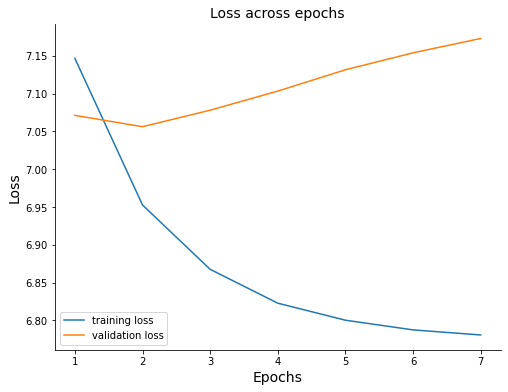

In [23]:
epoch = np.arange(1,8)

plt.figure(figsize=(8,6))

plt.plot(epoch, history.history['loss'], label='training loss')
plt.plot(epoch, history.history['val_loss'], label = 'validation loss')
plt.title('Loss across epochs', fontsize = 14)
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Loss', fontsize = 14)
sns.despine()
plt.legend()

plt.show()

The model seems to start over-fitting after 7 epochs. I will accept the early stopping result.

Next, I will save the trained embedding as a dictionary, with the keys being the word and values being the embedding vector.

In [24]:
import joblib
#Constructing a dictionary that maps word to vectors
my_w2v = dict()

for (k, v) in word_to_int.items():
    vector = np.array(model.layers[0](v)) #Pass the id into the model and get the trained embedding
    my_w2v[k] = vector                    #Map the word to the vector


joblib.dump(my_w2v, 'drive/MyDrive/data/my_own_w2v.pkl')

['drive/MyDrive/data/my_own_w2v.pkl']

Now that I have trained and saved my own Word2Vec embedding, it is ready to be used for my modeling. The modeling will start in the next notebook.  